# Basic regression: Predict fuel efficiency

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
from sklearn.model_selection import train_test_split
from sklearn import metrics as sk_metrics

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.0


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
src_df = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
df = src_df.copy()

In [6]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### Clean the data

The dataset contains a few unknown values:

In [7]:
df.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


Drop those rows to keep this initial tutorial simple:

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(392, 8)

In [10]:
df['Origin'].unique()

array([1, 3, 2])

The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Note: You can set up the `tf.keras.Model` to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Load CSV data](../load_data/csv.ipynb) tutorials for examples.

In [11]:
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [12]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA


In [13]:
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,False,False,True
1,15.0,8,350.0,165.0,3693.0,11.5,70,False,False,True
2,18.0,8,318.0,150.0,3436.0,11.0,70,False,False,True
3,16.0,8,304.0,150.0,3433.0,12.0,70,False,False,True
4,17.0,8,302.0,140.0,3449.0,10.5,70,False,False,True
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [14]:
X = df
y = df.pop('MPG')

### Split the data into training and test sets

Now, split the dataset into a training set and a test set.

You will use the test set in the final evaluation of your models.

Note, in a real life you should divide your data into 3 sets - train, validation, test

In [15]:
X_train, X_test_and_val, y_train, y_test_and_val = \
    train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
X_val, X_test, y_val, y_test = \
    train_test_split(X_test_and_val, y_test_and_val, test_size=0.5, shuffle=True)

In [17]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (313, 9), Validation: (39, 9), Test: (40, 9)


### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

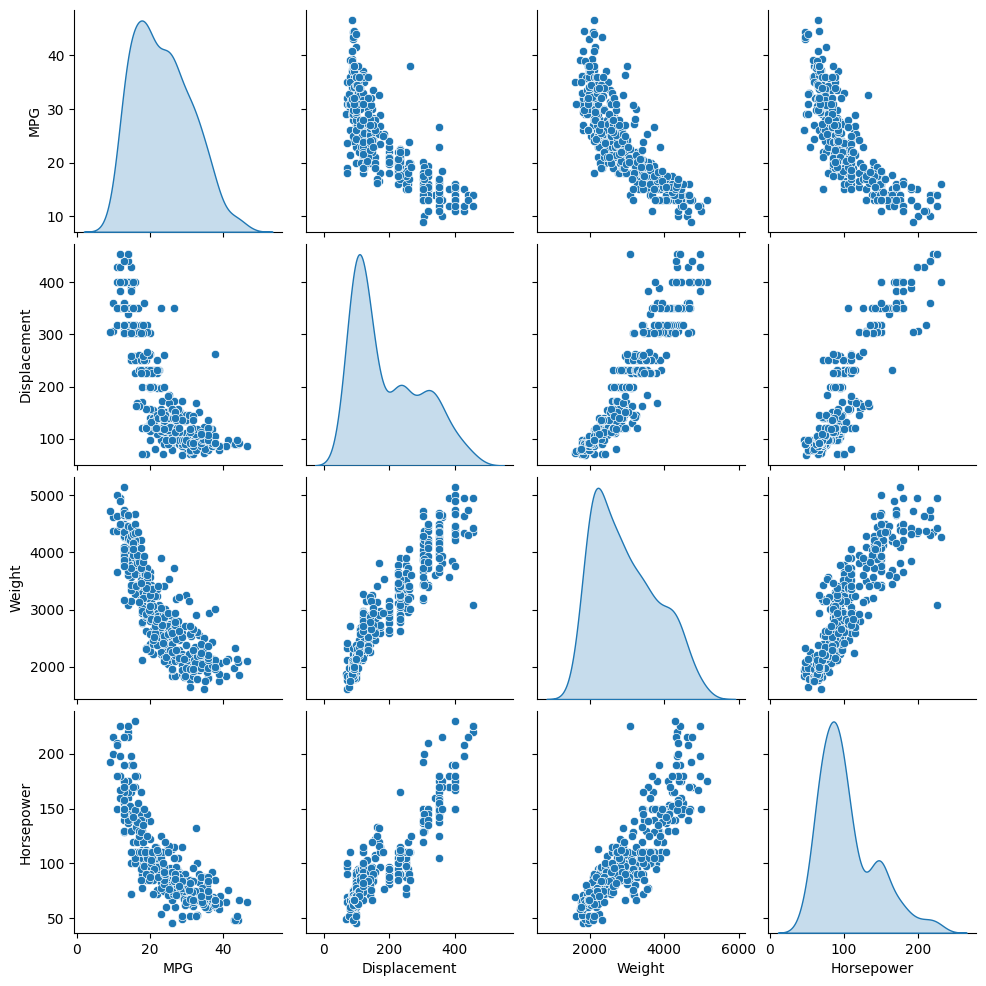

In [18]:
sns.pairplot(src_df[['MPG', 'Displacement', 'Weight', 'Horsepower']], diag_kind='kde')

In [19]:
src_df.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
MPG,1.000000,-0.775396,-0.804203,-0.778427,-0.831741,0.420289,0.579267,0.563450
Cylinders,-0.775396,1.000000,0.950721,0.842983,0.896017,-0.505419,-0.348746,-0.562543
Displacement,-0.804203,0.950721,1.000000,0.897257,0.932824,-0.543684,-0.370164,-0.609409
Horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
Weight,-0.831741,0.896017,0.932824,0.864538,1.000000,-0.417457,-0.306564,-0.581024
Acceleration,0.420289,-0.505419,-0.543684,-0.689196,-0.417457,1.000000,0.288137,0.205873
Model Year,0.579267,-0.348746,-0.370164,-0.416361,-0.306564,0.288137,1.000000,0.180662
Origin,0.563450,-0.562543,-0.609409,-0.455171,-0.581024,0.205873,0.180662,1.000000


Let's also check the overall statistics. Note how each feature covers a very different range:

In [20]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cylinders,313.0,5.460064,1.692509,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,192.386581,104.258927,68.0,98.0,151.0,260.0,455.0
Horsepower,313.0,103.373802,38.575154,46.0,75.0,92.0,122.0,225.0
Weight,313.0,2956.412141,849.726902,1613.0,2202.0,2800.0,3574.0,4997.0
Acceleration,313.0,15.657508,2.816688,8.0,14.0,15.5,17.3,24.8
Model Year,313.0,76.009585,3.720599,70.0,73.0,76.0,79.0,82.0


## Helper methods

In [21]:
def plot_loss(history, from_epoch=0, to_epoch=-1):
  plt.plot(history.history['loss'][from_epoch:to_epoch], label='loss')
  plt.plot(history.history['val_loss'][from_epoch:to_epoch], label='val_loss')
#   plt.ylim([0, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [22]:
test_results = {}

## Try I: Simple Linear regression

Before building a deep neural network model, start with linear regression.

This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

## Building sequential model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [25]:
X_train.shape

(313, 9)

In [45]:
# https://keras.io/
linear_model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    #output layer
    tf.keras.layers.Dense(units=1, activation=None, name="output_layer")
])

In [46]:
linear_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ output_layer (Dense)            │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

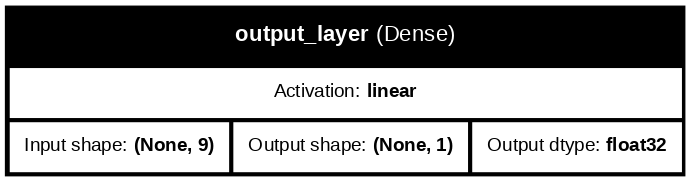

In [47]:
tf.keras.utils.plot_model(linear_model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, dpi=100, show_layer_activations=True)

## Compile the model

In [48]:
# linear_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.01),
#     loss=tf.keras.losses.MeanSquaredError()
#     )

In [49]:
linear_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

https://keras.io/api/optimizers/


https://keras.io/api/losses/

### We can now examine the untrained model, and even predict

In [40]:
linear_model

<Sequential name=sequential_5, built=True>

In [41]:
linear_model.layers

[<Dense name=output layer, built=True>]

In [42]:
linear_model.layers[0]

<Dense name=output layer, built=True>

In [43]:
linear_model.layers[0].get_weights()

[array([[-0.574],
        [-0.249],
        [-0.37 ],
        [ 0.642],
        [ 0.268],
        [-0.068],
        [-0.486],
        [-0.222],
        [-0.17 ]], dtype=float32),
 array([0.], dtype=float32)]

In [ ]:
len(linear_model.layers[0].get_weights())

In [ ]:
linear_model.layers[0].get_weights()[0]

In [ ]:
linear_model.layers[0].get_weights()[1]

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [50]:
linear_model.predict(X_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[-3295.698],
       [-2419.331],
       [-2301.505],
       [-3091.326],
       [-1621.251],
       [-1616.194],
       [-3267.901],
       [-3261.411],
       [-1477.531],
       [-1960.754]], dtype=float32)

In [51]:
linear_model.evaluate(X_train[:10], y_train[:10]) ** 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 6515530.0000


2552.5536233348753

In [ ]:
y_train[:10]

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

## Training the model

In [52]:
X_train.shape

# 32
# 10 iterations / batches
# epoch

(313, 9)

In [53]:
history = linear_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    verbose=1, # logging
    validation_data=(X_val, y_val),
)

# 313 / 32 =± 10 * 200 => 2000

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5332712.0000 - val_loss: 6015252.0000
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5027000.5000 - val_loss: 5834771.5000
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5006998.5000 - val_loss: 5656024.0000
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4980132.0000 - val_loss: 5481553.0000
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4805618.0000 - val_loss: 5311702.0000
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4667632.5000 - val_loss: 5145959.5000
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4342818.0000 - val_loss: 4985668.5000
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4249724.0000 - val_loss: 4827673.0000
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4100085.2500 - val_loss: 4673907.5000
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4063387.7500 - val_loss: 4522410.5000
Epoch 11/200
10/10 ━━━━━━━━━

In [ ]:
history.history

In [ ]:
linear_model.layers[0].get_weights()

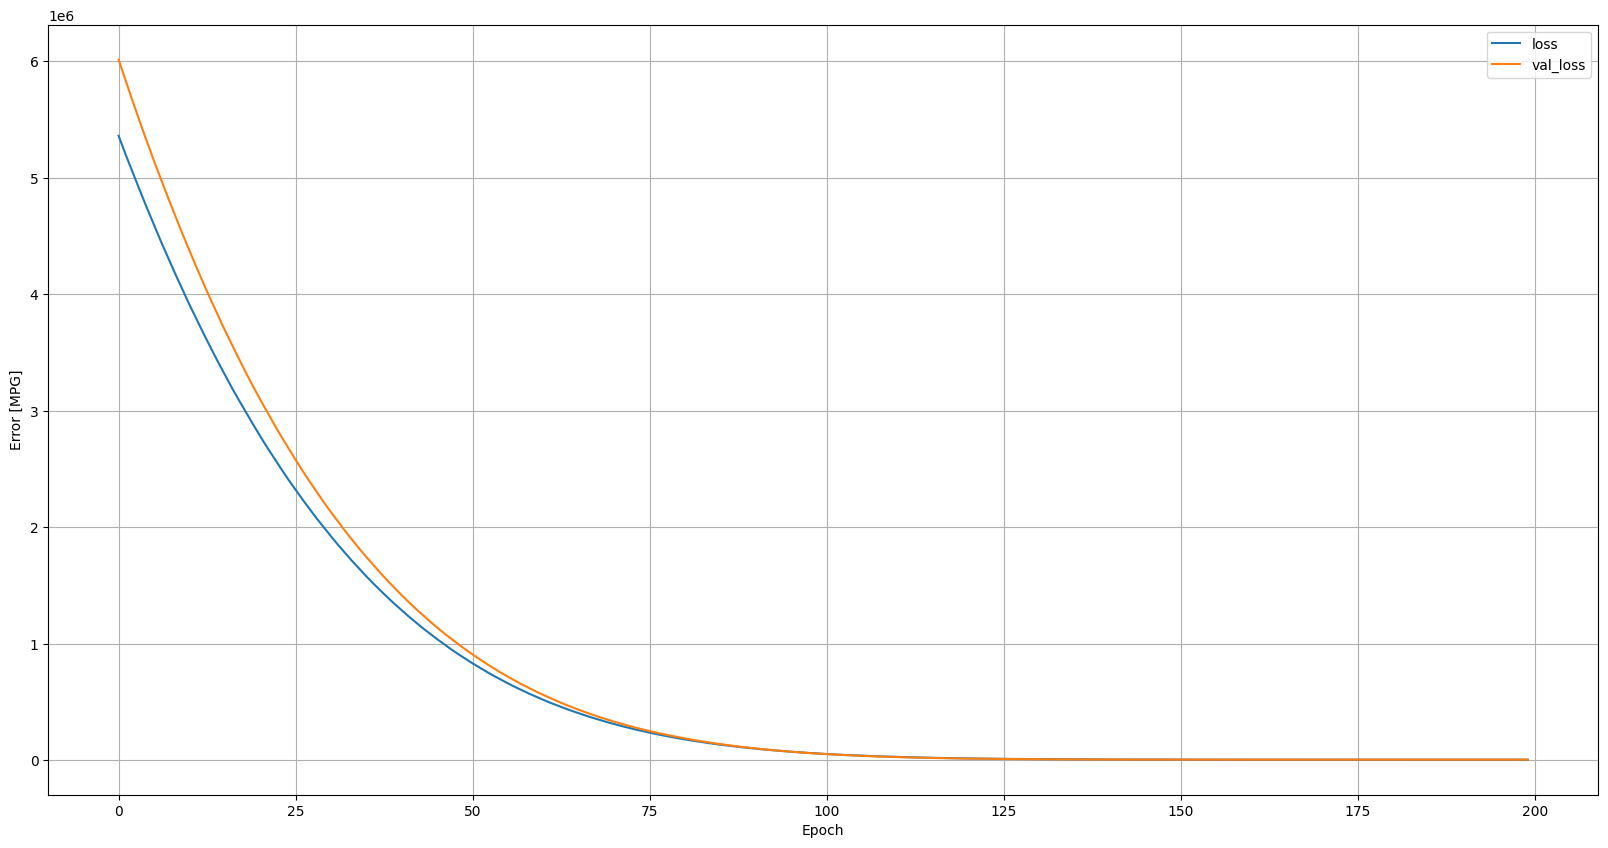

In [56]:
plot_loss(history, from_epoch=0, to_epoch=200)

In [57]:
linear_model.evaluate(X_val, y_val, verbose=0) ** 0.5

71.6440924051837

In [59]:
test_results['linear_model_not_normalized'] = linear_model.evaluate(X_val, y_val, verbose=0) ** 0.5

## Adding Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [ ]:
X_train.describe().transpose()[['mean', 'std']]

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [60]:
normalizer = tf.keras.layers.Normalization()

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [61]:
normalizer.adapt(np.array(X_train))

Calculate the mean and variance:

In [62]:
print(normalizer.mean)

tf.Tensor(
[[   5.46   192.387  103.374 2956.412   15.658   76.01     0.182    0.217
     0.601]], shape=(1, 9), dtype=float32)


In [63]:
print(normalizer.variance)

tf.Tensor(
[[     2.855  10835.195   1483.288 719729.         7.908     13.799
       0.149      0.17       0.24 ]], shape=(1, 9), dtype=float32)


In [64]:
print(normalizer.count)

<Variable path=sequential_5/normalization/count, shape=(), dtype=int64, value=0>


When the layer is called, it returns the input data, with each feature independently normalized:

In [66]:
X_train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
157,8,350.0,145.0,4440.0,14.0,75,False,False,True
191,6,225.0,100.0,3233.0,15.4,76,False,False,True
259,6,200.0,85.0,3070.0,16.7,78,False,False,True
136,8,302.0,140.0,4141.0,14.0,74,False,False,True
324,4,85.0,65.0,2110.0,19.2,80,False,True,False
...,...,...,...,...,...,...,...,...,...
292,8,360.0,150.0,3940.0,13.0,79,False,False,True
357,4,119.0,100.0,2615.0,14.8,81,False,True,False
113,6,155.0,107.0,2472.0,14.0,73,False,False,True
129,4,79.0,67.0,1950.0,19.0,74,False,True,False


** IMPORTANT! Must convert bool top int**

In [67]:
X_train[X_train.select_dtypes(['bool']).columns] = X_train.select_dtypes(['bool']).astype(int)

In [68]:
normalizer(X_train[:10])

<tf.Tensor: shape=(10, 9), dtype=float32, numpy=
array([[ 1.503,  1.514,  1.081,  1.749, -0.589, -0.272, -0.472, -0.527,
         0.815],
       [ 0.32 ,  0.313, -0.088,  0.326, -0.092, -0.003, -0.472, -0.527,
         0.815],
       [ 0.32 ,  0.073, -0.477,  0.134,  0.371,  0.536, -0.472, -0.527,
         0.815],
       [ 1.503,  1.053,  0.951,  1.396, -0.589, -0.541, -0.472, -0.527,
         0.815],
       [-0.864, -1.032, -0.996, -0.998,  1.26 ,  1.074, -0.472,  1.898,
        -1.226],
       [-0.864, -0.916, -0.399, -1.009,  0.3  , -1.079, -0.472,  1.898,
        -1.226],
       [ 1.503,  1.514,  1.99 ,  1.678, -1.265, -0.003, -0.472, -0.527,
         0.815],
       [ 1.503,  2.523,  3.158,  1.731, -2.012, -1.618, -0.472, -0.527,
         0.815],
       [-0.864, -0.916, -1.49 , -1.186,  1.9  , -0.81 ,  2.119, -0.527,
        -1.226],
       [-0.864, -0.35 , -0.295, -0.438, -0.412,  1.613, -0.472, -0.527,
         0.815]], dtype=float32)>

In [ ]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(X_train).numpy())

## Try II: Adding normalization

###Create a model with normalization layer

In [69]:
linear_model_with_normalization = tf.keras.Sequential([
    normalizer, # preprocessing layer
    tf.keras.layers.Dense(units=1, activation=None)
])

In [70]:
linear_model_with_normalization.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (313, 9)               │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [ ]:
tf.keras.utils.plot_model(linear_model_with_normalization,  show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, dpi=100, show_layer_activations=True)

In [71]:
linear_model_with_normalization = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[-1],)),
    normalizer, # preprocessing layer
    tf.keras.layers.Dense(units=1, activation=None)
])

In [72]:
linear_model_with_normalization.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (120.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 19 (80.00 B)

In [ ]:
tf.keras.utils.plot_model(linear_model_with_normalization,  show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, dpi=100, show_layer_activations=True)

###Compile the model

In [76]:
linear_model_with_normalization.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    # optimizer = 'adam',
    loss='mean_squared_error')

Train the model

In [ ]:
history = linear_model_with_normalization.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    verbose=1, # logging
    validation_data=(X_val, y_val)
    )

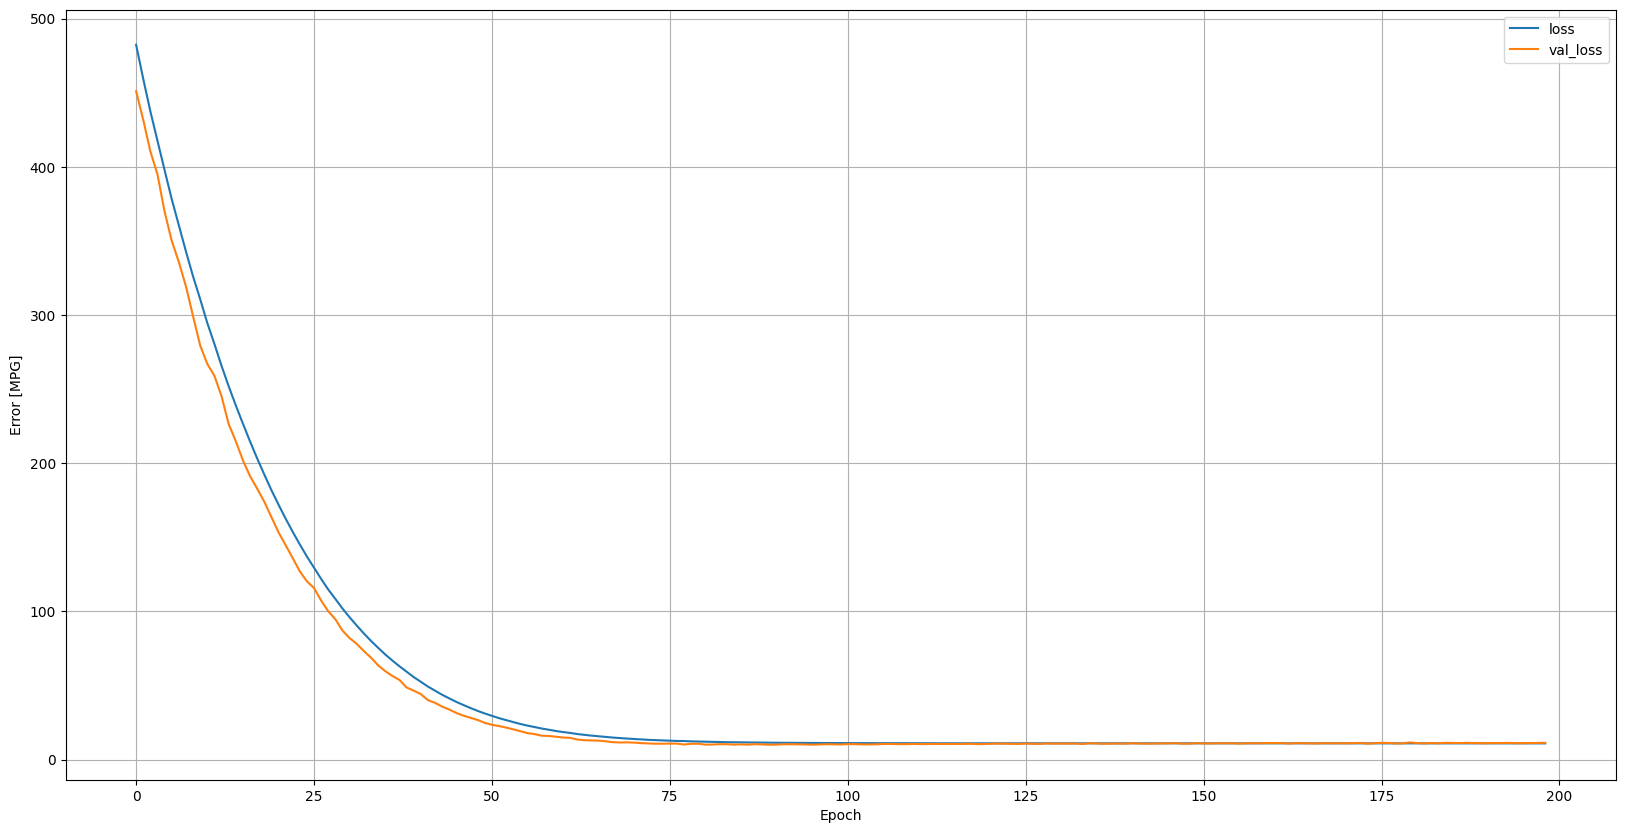

In [78]:
plot_loss(history)

###Evaluate the model

In [79]:
linear_model_with_normalization.evaluate(X_val, y_val, verbose=0) ** 0.5

3.322428237909305

In [ ]:
linear_model_with_normalization.layers[1].get_weights()

Collect the results on the val set for later:

In [82]:
test_results['linear_model_with_normalization'] = linear_model_with_normalization.evaluate(X_val, y_val, verbose=0) ** 0.5

In [83]:
test_results

{'linear_model_not_normalized': 71.6440924051837,
 'linear_model_with_normalization': 3.322428237909305}

## Feature engineering / manual feature extraction

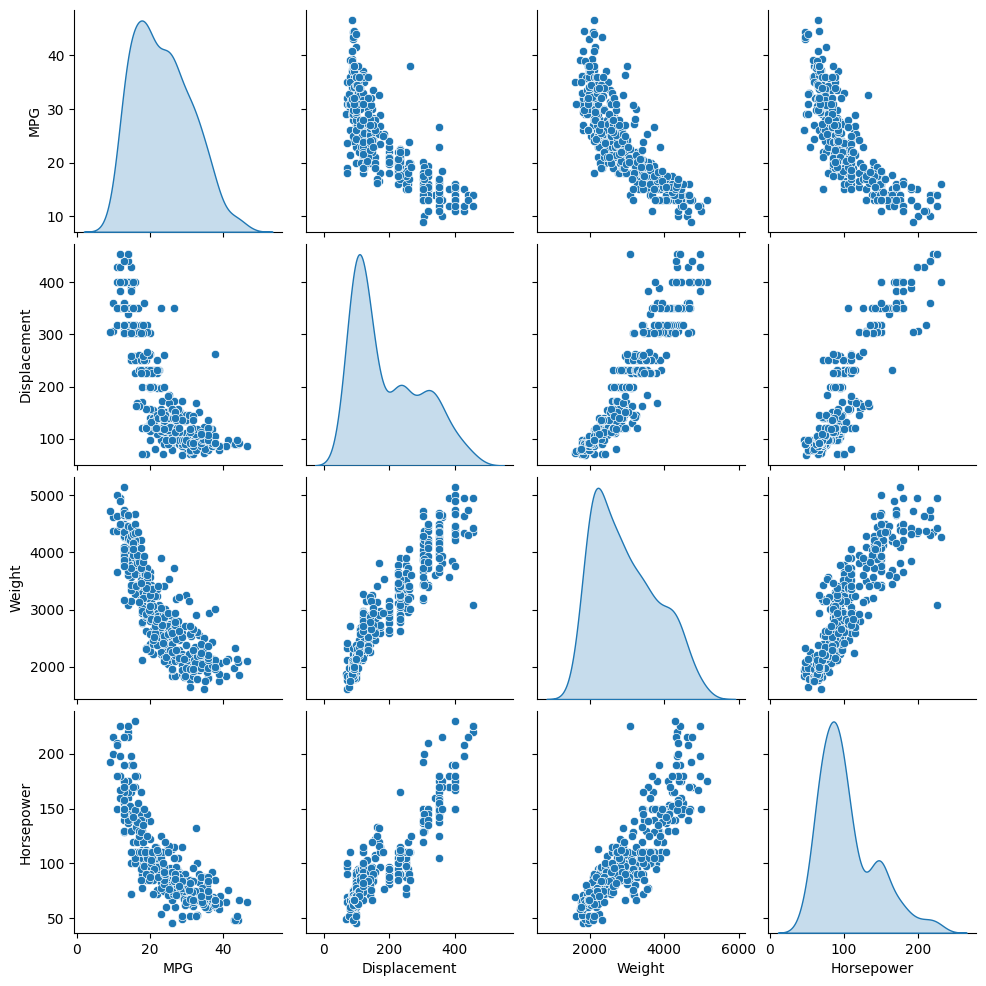

In [85]:
sns.pairplot(src_df[['MPG', 'Displacement', 'Weight', 'Horsepower']], diag_kind='kde')

In [86]:
df_eng = src_df.copy().dropna()

In [87]:
df_eng1 = src_df.copy().dropna()
df_eng1['Displacement_exp'] = df_eng1['Displacement'] ** -0.5

In [88]:
df_eng['Displacement_exp'] = df_eng['Displacement'] ** -0.5
df_eng['Weight_exp'] = df_eng['Weight'] ** 0.5
df_eng['Horsepower_exp'] = df_eng['Horsepower'] ** -0.5

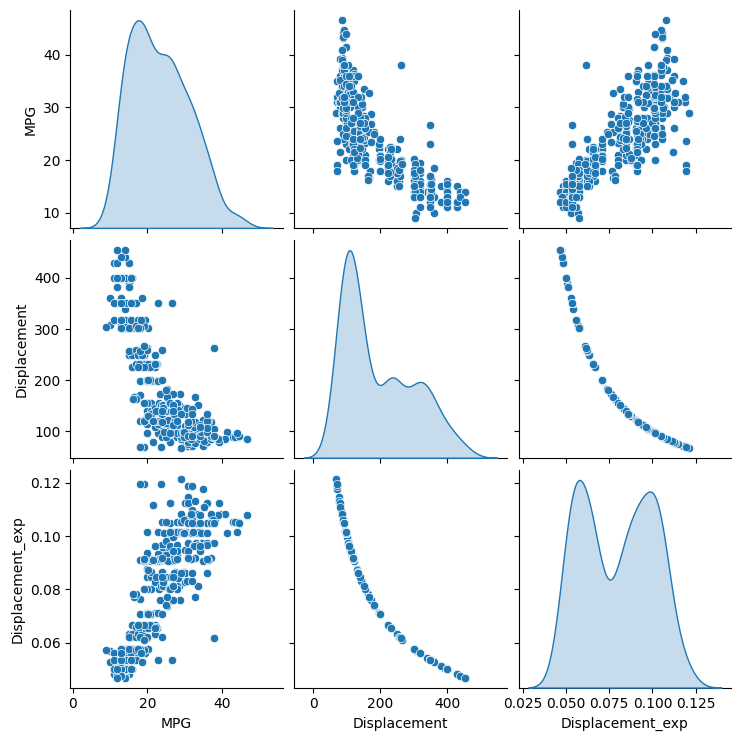

In [89]:
sns.pairplot(df_eng1[['MPG', 'Displacement', 'Displacement_exp']], diag_kind='kde')

In [90]:
X_eng = df_eng
y_eng = df_eng.pop('MPG')

In [91]:
X_train_eng, X_test_and_val_eng, y_train_eng, y_test_and_val_eng = \
    train_test_split(X_eng, y_eng, test_size=0.2, shuffle=True)

In [92]:
X_val_eng, X_test_eng, y_val_eng, y_test_eng = \
    train_test_split(X_test_and_val_eng, y_test_and_val_eng, test_size=0.5, shuffle=True)

In [93]:
normalizer_eng = tf.keras.layers.Normalization()

In [94]:
normalizer_eng.adapt(np.array(X_train_eng))

In [95]:
linear_model_eng = tf.keras.Sequential([
    normalizer_eng,
    tf.keras.layers.Dense(units=1, activation=None)
])

In [99]:
linear_model_eng.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_squared_error'
)

In [100]:
history = linear_model_eng.fit(
    x=X_train_eng,
    y=y_train_eng,
    batch_size=32,
    epochs=200,
    verbose=1, # logging
    validation_data=(X_val_eng, y_val_eng)
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 464.1573 - val_loss: 463.0762
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 429.9292 - val_loss: 447.3619
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 422.6174 - val_loss: 423.2952
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 409.2108 - val_loss: 403.2583
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 384.0493 - val_loss: 384.5566
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 364.1919 - val_loss: 366.4617
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 338.1418 - val_loss: 350.0439
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.4407 - val_loss: 330.4809
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 317.5024 - val_loss: 317.9574
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 287.8857 - val_loss: 301.3695
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 284.3445 - val_loss: 284.8506
Epoch 12/200
10/10

In [101]:
test_results['linear_model_eng'] = \
    linear_model_eng.evaluate(X_val_eng, y_val_eng, verbose=0) ** 0.5

In [102]:
test_results

{'linear_model_not_normalized': 71.6440924051837,
 'linear_model_with_normalization': 3.322428237909305,
 'linear_model_eng': 3.05675949499294}

## Regression with a deep neural network (DNN)

In the previous section, we implemented linear model.

Now we will implement DNN model.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

In [109]:
dnn_model = tf.keras.Sequential([
    # input
    tf.keras.layers.Input(shape=(X_train.shape[-1],)),

    #preprocessing
    normalizer,

    # hidden layer
    # layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(12, activation='relu'),

    tf.keras.layers.Dense(6, activation='relu'),

    tf.keras.layers.Dense(4, activation='relu'),

    #output layer
    tf.keras.layers.Dense(1, activation=None)])


In [110]:
dnn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250 (1004.00 B)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 19 (80.00 B)

In [111]:
dnn_model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [112]:
dnn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250 (1004.00 B)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 19 (80.00 B)

In [113]:
history = dnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    epochs=100,
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 402.4988 - val_loss: 74.7716
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 81.9738 - val_loss: 29.1347
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.2782 - val_loss: 16.1762
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.4134 - val_loss: 6.5889
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.9823 - val_loss: 5.6058
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.4223 - val_loss: 6.4637
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.6240 - val_loss: 4.9544
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.5621 - val_loss: 6.8009
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0159 - val_loss: 11.7252
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3025 - val_loss: 6.7584
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2848 - val_loss: 4.9580
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

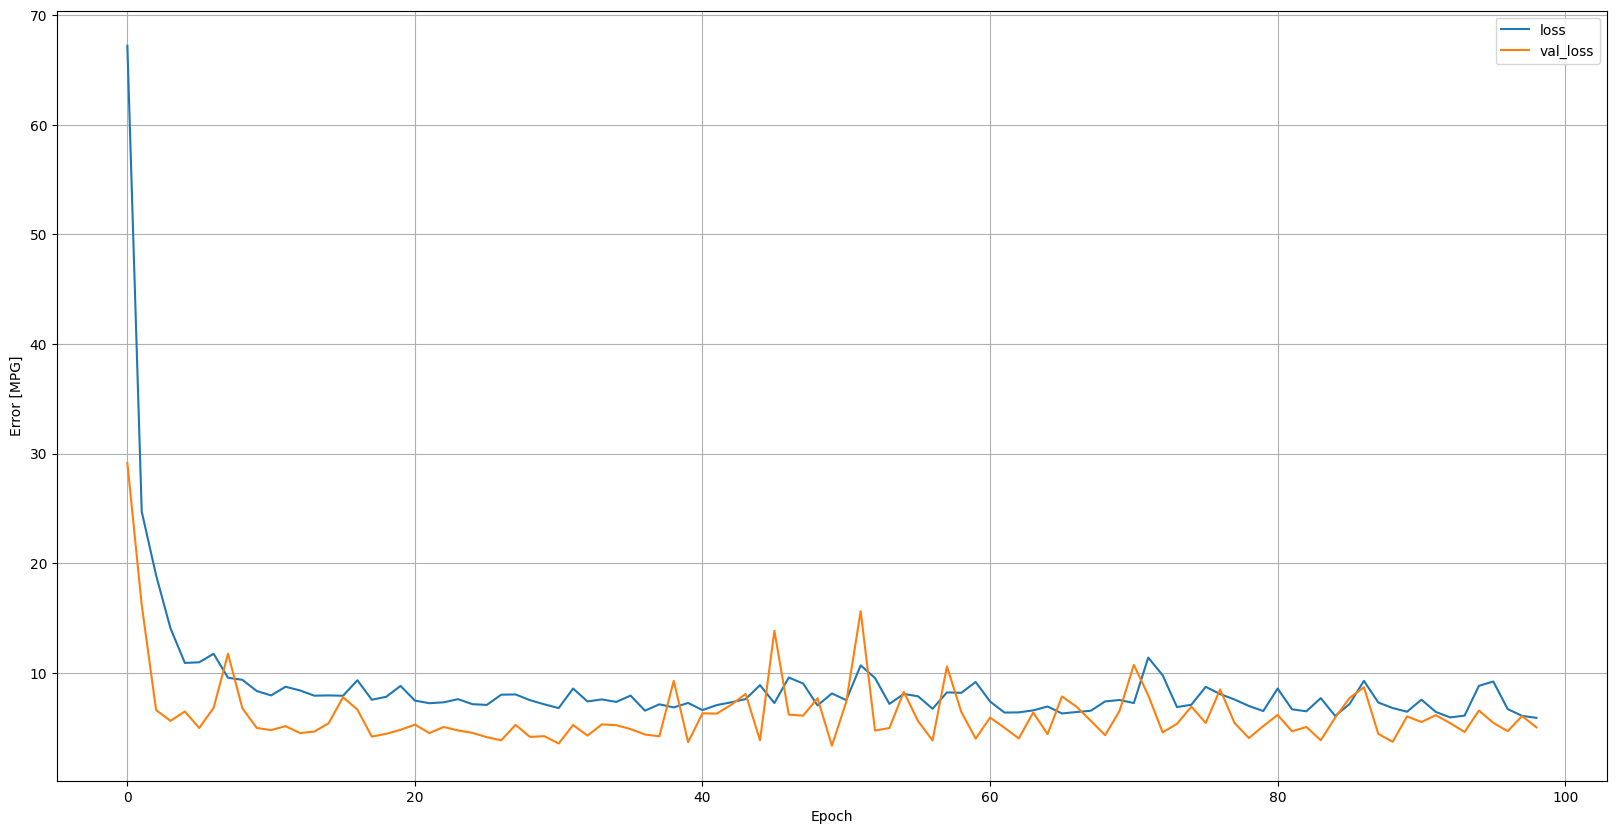

In [114]:
plot_loss(history, 1, 200)
# plot_loss(history, 300, 400)

In [115]:
dnn_model.evaluate(X_val, y_val, verbose=0) ** 0.5

2.2400122534893576

In [116]:
test_results['dnn_model'] = dnn_model.evaluate(X_val, y_val, verbose=0) ** 0.5

In [117]:
test_results

{'linear_model_not_normalized': 71.6440924051837,
 'linear_model_with_normalization': 3.322428237909305,
 'linear_model_eng': 3.05675949499294,
 'dnn_model': 2.2400122534893576}

In [ ]:
dnn_model.save('my_model.keras')

### Tuning the model

1. Adding more units (neurons) on the hiden layer

2. Adjusting learning rate - try increase / reduce

3. Try other optimizers

Collect the results on the test set:

## Performance

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['RMSE [MPG]']).transpose()

These results match the validation error observed during training.

## Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

In [ ]:
test_predictions = dnn_model.predict(X_val)
print(test_predictions[:10])

In [ ]:
y_test[:10]

In [ ]:
test_predictions = dnn_model.predict(X_val).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

In [ ]:
error = test_predictions - y_val
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

## Save the model

If you're happy with the model, save it for later use with `Model.save`:

In [ ]:
dnn_model.save('dnn_model.keras')

### Reload the model

If you reload the model, it gives identical output:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    X_test, y_test, verbose=0)

In [ ]:
reloaded.evaluate(X_test, y_test, verbose=0)

### You can continue training the reloaded model as well

In [ ]:
history = reloaded.fit(X_train,
    y_train,
    # batch_size=len(train_labels),
    validation_data=(X_test, y_test),
    verbose=1, epochs=100)

In [ ]:
plot_loss(history)

In [ ]:
reloaded.evaluate(X_test, y_test)

## Provide prediction for a totally new item

In [ ]:
X_train.columns

In [ ]:
X_train.describe()

In [ ]:
# SUBARU DL82
cylinders = 4
year=82
displacement = 108.7
horsepower = 67
weight = 2425
acceleration = 13.5

In [ ]:
test_data = {
    'Cylinders': [4],
    'Displacement': [108.7],
    'Horsepower': [67],
    'Weight': [2425],
    'Acceleration': [13.5],
    'Model Year': [82],
    'Europe': [0],
    'Japan': [1],
    'USA': [0]
}
test_df = pd.DataFrame(test_data)
# dnn_model.predict()

In [ ]:
test_df

In [ ]:
test_df

In [ ]:
dnn_model.predict(test_df)

In [ ]:
X_train.describe()